# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile, glob

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("/home/ubuntu/data/tensorflow/models/")
sys.path.append("/home/ubuntu/data/tensorflow/models/research")
sys.path.append("/home/ubuntu/data/tensorflow/models/research/slim")
from object_detection.utils import ops as utils_ops

# if tf.__version__ < '1.4.0':
#   raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [ ]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = '/home/ubuntu/data/tensorflow/my_workspace/training_demo/trained-inference-graphs/output_inference_graph'#'ssd_mobilenet_v1_coco_2017_11_17'
# MODEL_FILE = MODEL_NAME + '.tar.gz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/home/ubuntu/data/tensorflow/my_workspace/training_demo/annotations/', 'label_map_focus.pbtxt')

NUM_CLASSES = 1

## Download Model
You don't need this code for a model already in your local directory

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8) if \
        len(np.array(image).shape) == 3 else \
        np.array(image.getdata()).reshape((im_height, im_width, 1)).astype(np.uint8)

# Detection

In [22]:
PATH_TO_TEST_IMAGES_DIR = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/snapshot-safari/snapshot-serengeti/subject_set/'
TEST_IMAGE_PATHS = glob.glob('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/snapshot-safari/snapshot-serengeti/subject_set/*.jpg')
TEST_IMAGE_PATHS = TEST_IMAGE_PATHS # Subsetting to small number of images for test
IMAGE_SIZE = (w, h)

In [ ]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.1), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [ ]:
bb_hashmap = {}
min_threshold = 0.9
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    if (len(np.array(image).shape) == 3):
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        
        # Considering the default dpi of matplotlib, calculating the figure size to save
        y0, x0, c = image_np.shape
        h = y0/72
        w = x0/72
        IMAGE_SIZE = (w, h)
        
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        output_dict = run_inference_for_single_image(image_np, detection_graph)
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          line_thickness=8,
          min_score_thresh=min_threshold,
          skip_labels=True,
          skip_scores=True,
          agnostic_mode=True
        )
#         plt.figure(figsize=IMAGE_SIZE, frameon=False)
#         plt.xticks([])
#         plt.yticks([])
#         plt.imshow(image_np)
        # make a figure without the frame
        fig = plt.figure(frameon=False, figsize=IMAGE_SIZE)
        # make the content fill the whole figure
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        # draw your image
        ax.imshow(image_np)
#         plt.title('{0}'.format(image_path[-14:])) # This is in case you want the title on the image
#         plt.savefig('/home/ubuntu/data/test.jpg') # This one was for testing
        plt.savefig('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/snapshot-safari/snapshot-serengeti/subject_set_upload/{0}'.format(image_path[-14:])) # saving image with boxes on the disk
        plt.gcf().clear()
        bb_hashmap[image_path[-14:]] = {
          'detection_boxes' : output_dict['detection_boxes'][0:sum(output_dict['detection_scores']>=min_threshold)],
          'detection_scores' : output_dict['detection_scores'][0:sum(output_dict['detection_scores']>=min_threshold)]
        }

/home/ubuntu/test_env/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [26]:
bb_hashmap

{'ASG000by3x.jpg': {'detection_boxes': array([[0.3021284, 0.4295665, 0.9861699, 0.751856 ]], dtype=float32),
  'detection_scores': array([0.9997253], dtype=float32)},
 'ASG000crpx.jpg': {'detection_boxes': array([[6.7834604e-01, 3.2007763e-05, 1.0000000e+00, 2.2251019e-01]],
        dtype=float32),
  'detection_scores': array([0.99945635], dtype=float32)},
 'ASG000zfex.jpg': {'detection_boxes': array([[0.28450438, 0.5389161 , 0.7448592 , 0.8990803 ]], dtype=float32),
  'detection_scores': array([0.999928], dtype=float32)},
 'ASG000zt3l.jpg': {'detection_boxes': array([[0.22771439, 0.62534463, 0.707446  , 0.9937807 ]], dtype=float32),
  'detection_scores': array([0.9998247], dtype=float32)}}

Save the bb_hashmap to the local path. This is very important because we want to retain the bounding box information that is used in the subject set.

In [ ]:
# bb_hashmap
import csv
with open('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/snapshot-safari/snapshot-serengeti/bb_hashmap.csv', 'w') as f:
    for key in bb_hashmap.keys():
        f.write("%s,%s\n"%(key,bb_hashmap[key]))

Create a list of event id's and store it in the csv file. This is a good to have and is beneficial when creating the manifest.

In [37]:
# capture_event_id = []
with open('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/snapshot-safari/snapshot-serengeti/capture_event_id.csv', 'w') as f:
    f.write("CaptureEventID\n")
    for k in bb_hashmap.keys():
#         capture_event_id.append(k)
        f.write("%s\n"% k[:-4])
# capture_event_id

#### My testing zone beyound this point

In [20]:
graph = detection_graph
with graph.as_default():
    with tf.Session() as sess:
        # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
          ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                  tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
        
        # Run inference
        output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]
#         print(output_dict['detection_scores'], output_dict['detection_classes'])

In [ ]:
width = image_np.shape[1]  # Number of columns
height = image_np.shape[0]  # number of rows
category_index = label_map_util.create_category_index(categories)

for i in range(len(output_dict['detection_boxes'])):
    class_name = category_index[output_dict['detection_classes'][i]]['name']
    print("{class: %s, prediction: %s, boundingbox: %s,%i,%i,%i,%i,%i,%i,%i}"
          % (class_name,
             output_dict['detection_scores'][i],
             TEST_IMAGE_PATHS[2],
             width,
             height,
             output_dict['detection_classes'][i],
             int(width * output_dict['detection_boxes'][i][1]),  # The boxes are given normalized and in row/col order
             int(height * output_dict['detection_boxes'][i][0]),
             int(width * output_dict['detection_boxes'][i][3]),
             int(height * output_dict['detection_boxes'][i][2])
             ))

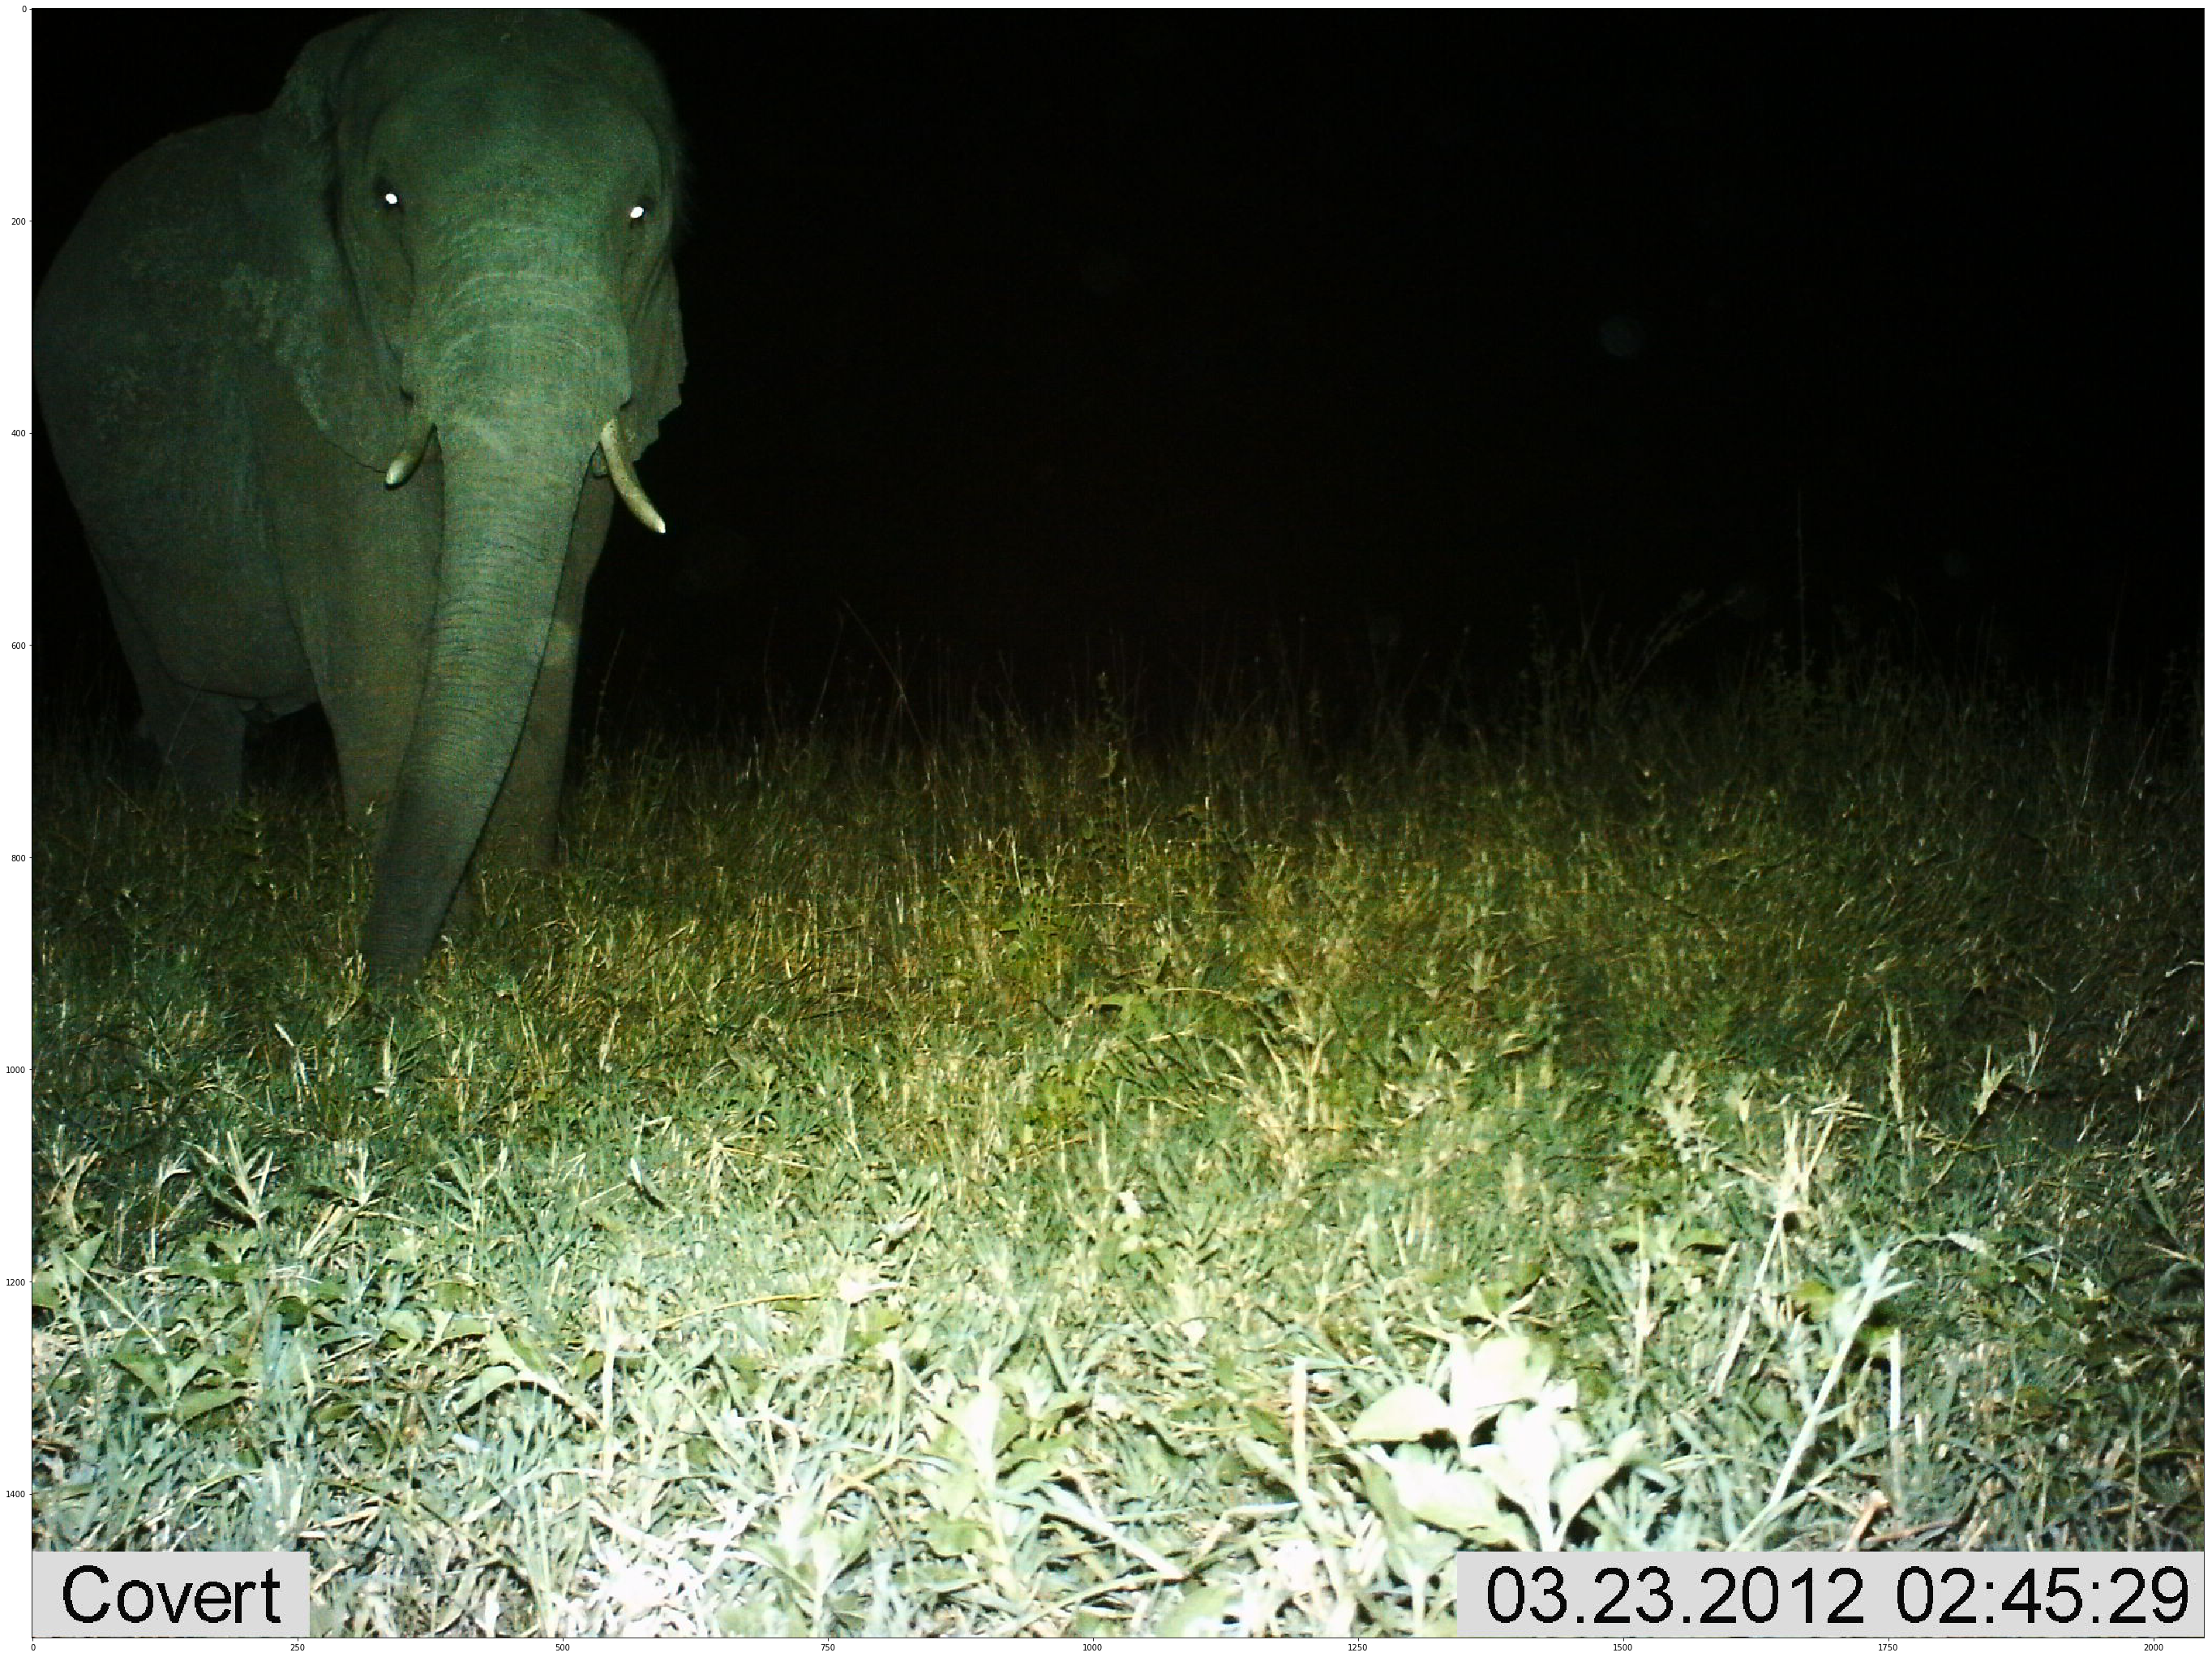

In [64]:
plt.figure(figsize=(48, 48))
plt.imshow(image_np)

In [27]:
def load_label_map(PATH_TO_LABELS, NUM_CLASSES):
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return label_map, categories, category_index

def get_per_image_prediction(output_dict, image, threshold_detection_score=0.5):
    image_np = load_image_into_numpy_array(image)
    label_map, categories, category_index = load_label_map(PATH_TO_LABELS, NUM_CLASSES)
    width = image_np.shape[1]  # Number of columns
    height = image_np.shape[0]  # number of rows
    category_index = label_map_util.create_category_index(categories)

    image_bb_prediction = []

    for i in range(len(output_dict['detection_boxes'])):
        bb_prediction = {}
        if output_dict['detection_scores'][i] > threshold_detection_score:
            # class_name = category_index[output_dict['detection_classes'][i]]['name']
            bb_prediction['class_name'] = category_index[output_dict['detection_classes'][i]]['name']
            bb_prediction['detection_scores'] = output_dict['detection_scores'][i]
            bb_prediction['detection_classes'] = output_dict['detection_classes'][i]
            bb_prediction['bb_xmin'] = int(width * output_dict['detection_boxes'][i][1])
            bb_prediction['bb_ymin'] = int(height * output_dict['detection_boxes'][i][0])
            bb_prediction['bb_xmax'] = int(width * output_dict['detection_boxes'][i][3])
            bb_prediction['bb_ymax'] = int(height * output_dict['detection_boxes'][i][2])
            bb_prediction['width'] = width
            bb_prediction['height'] = height
            image_bb_prediction.append(bb_prediction)
    return image_bb_prediction

In [32]:
label_map, categories, category_index = load_label_map(PATH_TO_LABELS, NUM_CLASSES)
image = Image.open(TEST_IMAGE_PATHS[4])
image_np = load_image_into_numpy_array(image)
output_dict = run_inference_for_single_image(image_np, detection_graph)
get_per_image_prediction(output_dict, image, threshold_detection_score=0.5)

[{'bb_xmax': 571,
  'bb_xmin': 517,
  'bb_ymax': 866,
  'bb_ymin': 802,
  'class_name': 'Wildebeest',
  'detection_classes': 1,
  'detection_scores': 0.81137663,
  'height': 1536,
  'width': 2048},
 {'bb_xmax': 1328,
  'bb_xmin': 1230,
  'bb_ymax': 850,
  'bb_ymin': 796,
  'class_name': 'Zebra',
  'detection_classes': 2,
  'detection_scores': 0.7470913,
  'height': 1536,
  'width': 2048},
 {'bb_xmax': 146,
  'bb_xmin': 98,
  'bb_ymax': 883,
  'bb_ymin': 851,
  'class_name': 'GazelleThomsons',
  'detection_classes': 4,
  'detection_scores': 0.6469651,
  'height': 1536,
  'width': 2048},
 {'bb_xmax': 565,
  'bb_xmin': 523,
  'bb_ymax': 869,
  'bb_ymin': 802,
  'class_name': 'Zebra',
  'detection_classes': 2,
  'detection_scores': 0.5181423,
  'height': 1536,
  'width': 2048}]